In [258]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [259]:
np.random.seed(13)
rng = np.random

In [260]:
# --------------------
# Config
# --------------------
n_users = 300
n_artists = 30
n_tracks_avg = 16
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 3, 31)
artist_weighting = 0.5
track_weighting = 0.7
weekend_effect=1.1
#short_session_prob=0.15
#short_session_choices=(1,2,3)
#lognorm_mu=1.0           
#lognorm_sigma=0.9
avg_inter_track_sec=210
std_inter_track_sec=45

In [261]:
# --------------------
# Artist + Track metadata
# --------------------
artist_ids = [f"artist_{i+1}" for i in range(n_artists)]
tracks = []

ranks = np.arange(1, n_artists + 1)
artist_weights = 1 / ranks ** artist_weighting
artist_weights = artist_weights / artist_weights.sum()

for a_idx, aid in enumerate(artist_ids):
    n_tracks = np.random.randint(1/2*n_tracks_avg, 2*n_tracks_avg)
    ranks = np.arange(1, n_tracks + 1)
    weighting = rng.uniform(0,track_weighting)
    track_weights = 1 / ranks ** weighting
    track_weights = track_weights / track_weights.sum()
    for t in range(n_tracks):
        t_len = np.random.normal(loc=avg_inter_track_sec, 
                                 scale=std_inter_track_sec)
        tracks.append({
            "artist_id": aid, 
            "track_id": f"{aid}_track_{t+1}", 
            "track_len_sec":t_len,
            "artist_popularity": artist_weights[a_idx],
            "track_popularity": track_weights[t],
            "total_track_popularity": artist_weights[a_idx] * track_weights[t]
                      })
tracks_df = pd.DataFrame(tracks)



In [262]:
tracks_df.head()

,artist_id,track_id,track_len_sec,artist_popularity,track_popularity,total_track_popularity
0,artist_1,artist_1_track_1,234.836382,0.104328,0.097664,0.010189
1,artist_1,artist_1_track_2,179.183451,0.104328,0.072737,0.007589
2,artist_1,artist_1_track_3,237.418483,0.104328,0.061220,0.006387
3,artist_1,artist_1_track_4,274.281367,0.104328,0.054172,0.005652
4,artist_1,artist_1_track_5,188.201603,0.104328,0.049269,0.005140


In [263]:
# --------------------
# User metadata
# --------------------
mixed_sesh_pct = 0.5 # are they less mixed < 0.5 = single artists
popular_music_fan = 0.5 # are they more into popular artists > 0.5 or even mix
songs_per_sesh_mu = 6
sesh_per_day_mu = 2
mixed_sesh_time = 0.5 # are they a random sesh < 0.5 or ordered sesh i.e. morning
skip_prob = 0.2 # lower means less chance of skipping songs

users = []
for user_id in range(1, n_users + 1):
    users.append(
        {"user_id": user_id,
        "mix_sesh": rng.uniform(),
        "pop_fan": rng.uniform(),
        "sesh_len": np.clip(rng.poisson(songs_per_sesh_mu), 1, 10000),
        "sesh_num": np.clip(rng.poisson(sesh_per_day_mu), 1, 10000),
        "skip_prob": np.clip(rng.normal(0.4,.25),0.05,0.9)}
    )
users_df = pd.DataFrame(users)

In [264]:
users_df.head()

,user_id,mix_sesh,pop_fan,sesh_len,sesh_num,skip_prob
0,1,0.770236,0.449934,7,1,0.722269
1,2,0.678292,0.198552,7,2,0.449958
2,3,0.631687,0.335670,2,1,0.155921
3,4,0.583200,0.587551,8,2,0.538524
4,5,0.622390,0.508089,5,1,0.514179


In [265]:
# --------------------
# Stream Generation
# --------------------
date_range = pd.date_range(start_date, end_date, freq="D")
streams = []

currrent_sesh = 0
for user_id in users_df['user_id']:

    temp_user_df = users_df[users_df['user_id'] == user_id].iloc[0]

    for day in date_range:
        
        day_factor = weekend_effect if day.weekday() >= 5 else 1.0
        n_sessions = rng.poisson(temp_user_df['sesh_num'] * day_factor)

        if n_sessions == 0:
            continue

        for sesh_i in range(n_sessions):
            n_streams = np.clip(rng.poisson(temp_user_df['sesh_len'] * day_factor), 1, 10000)

            session_start = pd.Timestamp(
                year=day.year, month=day.month, day=day.day,
                hour=rng.randint(0, 24),
                minute=rng.randint(0, 60),
                second = rng.randint(0, 60)
            )

            ts = session_start

            if rng.random() < temp_user_df['mix_sesh']:
                # Mixed session: all tracks are weighted by track popularity
                session_tracks = tracks_df.sample(
                    n=n_streams,
                    replace=True,
                    weights=tracks_df['total_track_popularity']
                )
            else:
                # Focused session: pick one artist, then sample from their tracks
                artist_choice = tracks_df['artist_id'].sample(
                    n=1,
                    weights=tracks_df['artist_popularity']
                ).iloc[0]
                
                session_tracks = tracks_df.query(
                    "artist_id == @artist_choice"
                ).sample(
                    n=n_streams,
                    replace=True
                )

            for _, track in session_tracks.iterrows():
                
                track_len = track['track_len_sec']
                if np.random.rand() < temp_user_df['skip_prob']:
                    skip_fraction = np.random.uniform(0.01, 0.9)  
                    listen_time = track_len * skip_fraction
                else:
                    listen_time = track_len

                streams.append({
                    "user_id": user_id,
                    "session_id": currrent_sesh,
                    "timestamp": ts,
                    "artist_id": track['artist_id'],
                    "track_id": track['track_id'],
                    "track_duration_sec": track_len,
                    "listen_duration_sec": listen_time,
                    "is_bot": False
                })

                ts += pd.Timedelta(seconds=listen_time)
            currrent_sesh+=1

In [266]:
streams_df = pd.DataFrame(streams)

In [267]:
streams_df.sort_values(['timestamp'])

,user_id,session_id,timestamp,artist_id,track_id,track_duration_sec,listen_duration_sec,is_bot
123040,109,19246,2025-01-01 00:06:13.000000000,artist_23,artist_23_track_12,206.128160,206.128160,False
72964,64,11614,2025-01-01 00:07:43.000000000,artist_6,artist_6_track_1,264.156441,264.156441,False
123041,109,19246,2025-01-01 00:09:39.128160177,artist_23,artist_23_track_9,259.961091,259.961091,False
351012,293,55021,2025-01-01 00:10:15.000000000,artist_8,artist_8_track_26,208.470316,208.470316,False
72965,64,11614,2025-01-01 00:12:07.156440563,artist_13,artist_13_track_18,210.869831,210.869831,False
...,...,...,...,...,...,...,...,...
323940,267,50679,2025-04-01 00:11:45.145645144,artist_20,artist_20_track_1,181.353628,181.353628,False
90390,76,14073,2025-04-01 00:12:24.707957020,artist_2,artist_2_track_3,156.754249,156.754249,False
323941,267,50679,2025-04-01 00:14:46.499273317,artist_20,artist_20_track_6,271.092390,271.092390,False
323942,267,50679,2025-04-01 00:19:17.591663186,artist_20,artist_20_track_2,175.457508,99.694742,False


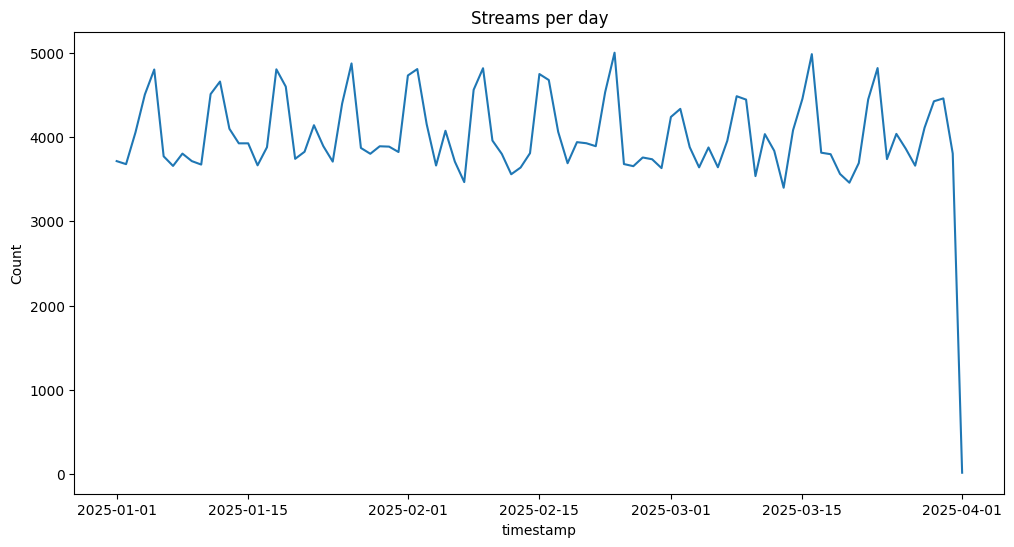

In [268]:
vc = (streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

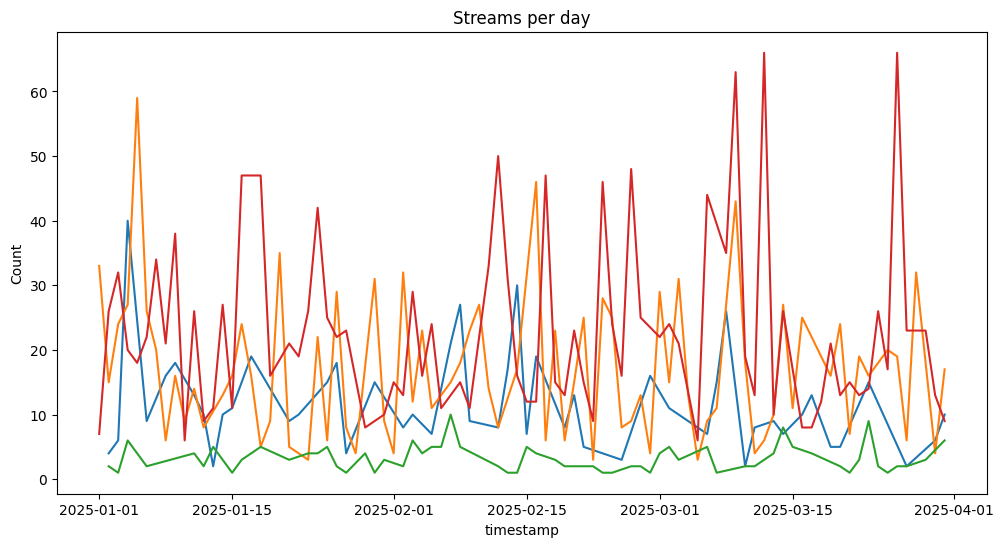

In [269]:
vc = (streams_df[streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==3])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==4])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

In [270]:
def inject_long_session_bot(streams_df, user_id, start_time, duration_hours=5, artist_id=None):

    max_sess = streams_df['session_id'].max() if 'session_id' in streams_df.columns else 0
    new_session_id = max_sess + 1

    if artist_id is None:
        artist_id = streams_df['artist_id'].sample(1).iloc[0]
    track_length_sec = avg_inter_track_sec

    n_streams = int(duration_hours * 3600 / track_length_sec)
    timestamps = [start_time + pd.Timedelta(seconds=i*track_length_sec) for i in range(n_streams)]

    tracks_sampled = tracks_df[tracks_df['artist_id'] == artist_id].sample( \
            n=n_streams, replace=True)

    bot_streams = pd.DataFrame({
        'user_id': [user_id] * n_streams,
        'session_id': [new_session_id] * n_streams,
        'timestamp': timestamps,
        'artist_id': [artist_id] * n_streams,
        'track_id': tracks_sampled['track_id'],
        'track_duration_sec': tracks_sampled['track_len_sec'],
        'listen_duration_sec':  tracks_sampled['track_len_sec'],
        'is_bot': True
    })

    return pd.concat([streams_df, bot_streams], ignore_index=True)

In [ ]:
def inject_bot_sessions(streams_df, n_bots, n_sessions, bot_fn, start_time, duration_hours, wait_hours, artist_id=None):
    
    bot_user_ids = [streams_df['user_id'].max() + 1 + i for i in range(n_bots)]
    durations = [duration_hours* 2*(i+1)/n_bots for i in range(n_bots)]
    waits = [wait_hours* 2*(i+1)/n_bots for i in range(n_bots)]
    
    split_points = sorted([rng.randint(0, n_sessions) for _ in range(n_bots - 1)])
    split_points.insert(0, 0)
    split_points.append(n_sessions)
    sessions_per_bot = [split_points[i+1] - split_points[i] for i in range(n_bots)]

    timestamps = [[start_time + pd.Timedelta(days=j) + pd.Timedelta(hours=i*durations[j]) + \
                  pd.Timedelta(hours=i*waits[j]) for i in range(sessions_per_bot[j])] \
                    for j in range(n_bots)]
    temp_df = streams_df
    for i in range(len(bot_user_ids)):
        for timestamp in timestamps[i]:
            temp_df = bot_fn(temp_df, bot_user_ids[i], timestamp, durations[i], artist_id)

    return temp_df

In [320]:
bot_streams_df = inject_bot_sessions(streams_df, 30, 300, inject_long_session_bot, 
            pd.Timestamp(year=2025, month=1, day=11, hour=15, minute=30, second=0),
            duration_hours=5,
            wait_hours=13)

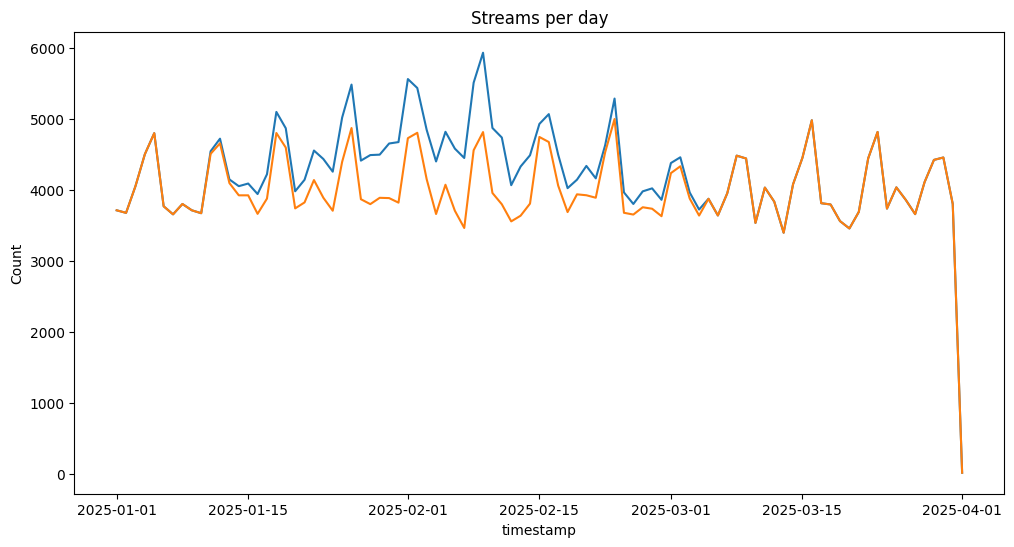

In [321]:
vc = (bot_streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

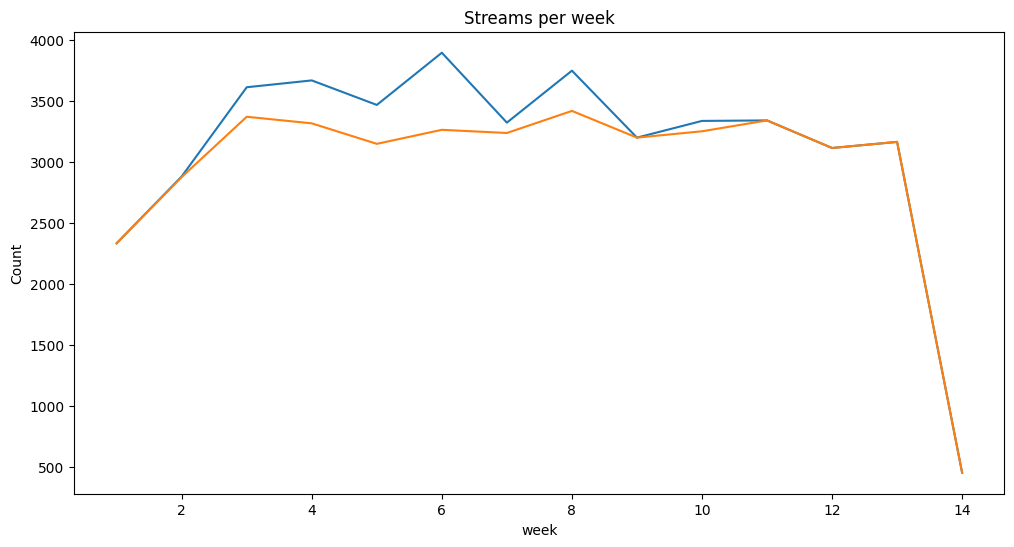

In [322]:
vc = (bot_streams_df[(bot_streams_df['artist_id']=='artist_1') ])['timestamp'].dt.isocalendar().week.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['artist_id']=='artist_1'])['timestamp'].dt.isocalendar().week.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per week')
plt.show()

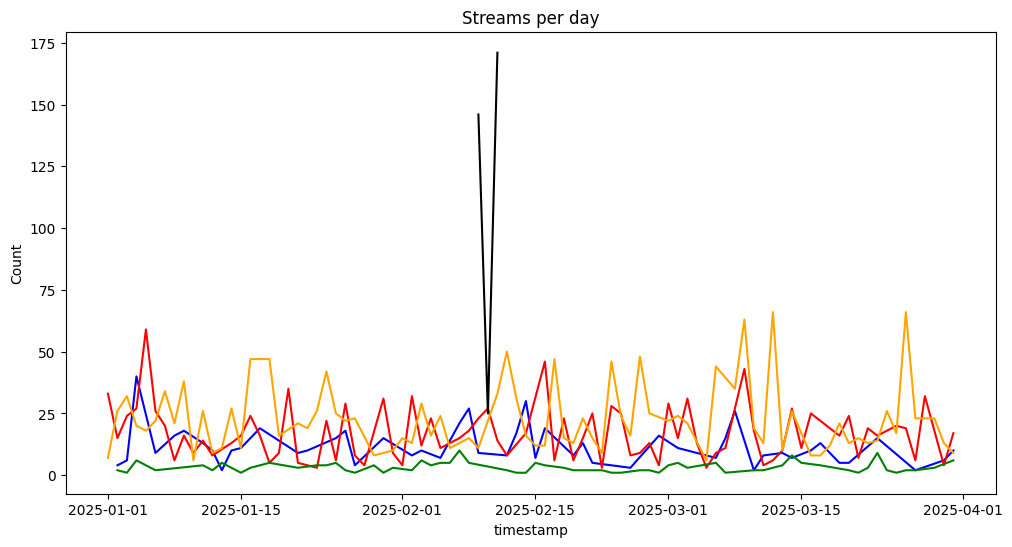

In [323]:
vc = (bot_streams_df[bot_streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='blue')

vc = (bot_streams_df[bot_streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='red')

vc = (bot_streams_df[bot_streams_df['user_id']==3])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='green')

vc = (bot_streams_df[bot_streams_df['user_id']==4])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='orange')

vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='black')

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

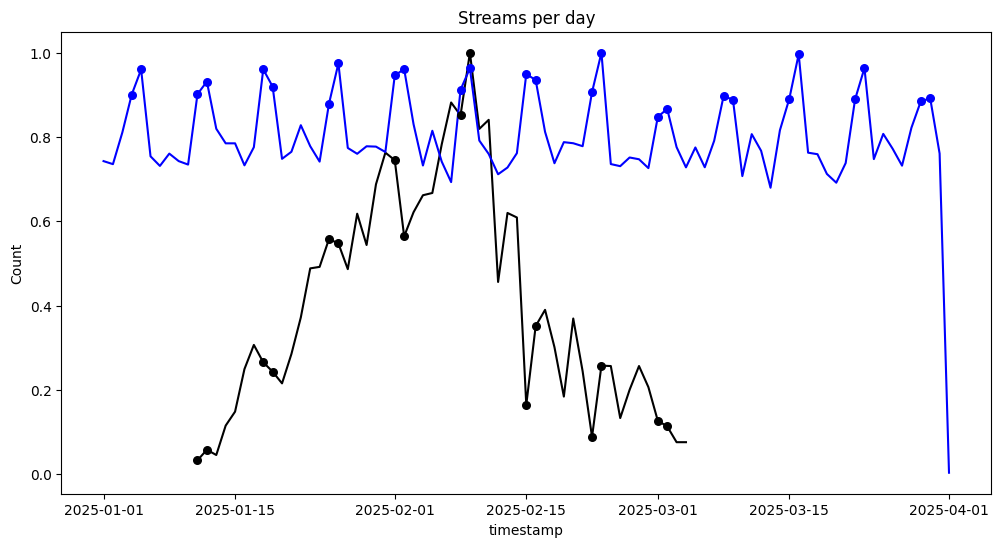

In [324]:
fig, ax = plt.subplots(figsize=(12, 6))
vc_bots = (bot_streams_df[bot_streams_df['is_bot']==True])['timestamp'].dt.date.value_counts().sort_index()
vc_bots = vc_bots / vc_bots.max()
vc_bots.plot(kind='line', figsize=(12, 6), color='black')
vc_bots.index = pd.to_datetime(vc_bots.index)
is_weekend = (vc_bots.index.dayofweek == 5) | (vc_bots.index.dayofweek == 6)
weekend_counts = vc_bots[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='black', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['is_bot']==False])['timestamp'].dt.date.value_counts().sort_index()
vc = vc / vc.max()
vc.plot(kind='line', figsize=(12, 6), color='blue')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='blue', s=30, zorder=5)


plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

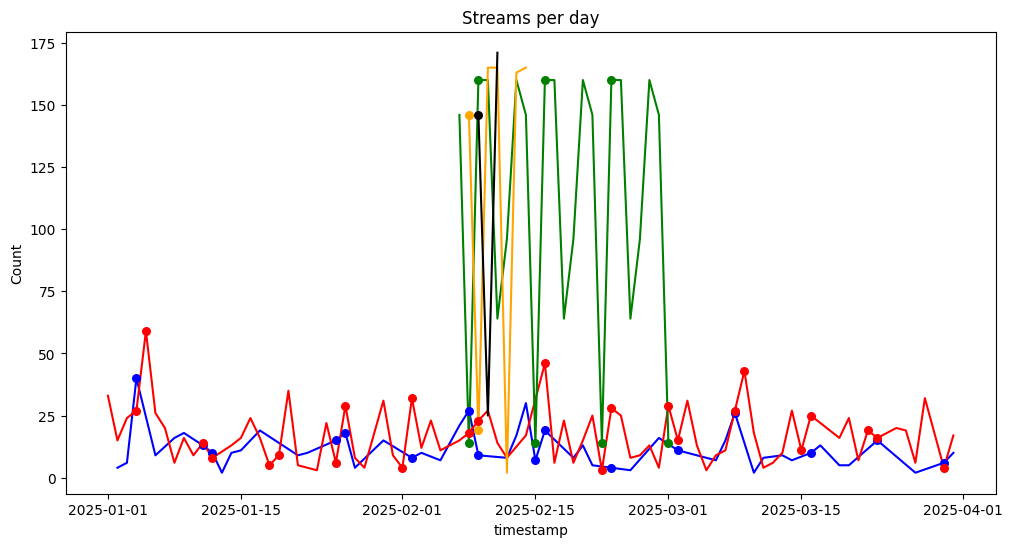

In [325]:
fig, ax = plt.subplots(figsize=(12, 6))
vc = (bot_streams_df[bot_streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='blue')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='blue', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='red')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='red', s=30, zorder=5)


vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()-2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='green')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='green', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()-1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='orange')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='orange', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', color='black')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='black', s=30, zorder=5)

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()